In [1]:
import numpy as np
import matplotlib.pyplot as plt
import omegaqe
from omegaqe.fields import Fields
from scipy.interpolate import InterpolatedUnivariateSpline
from omegaqe.powerspectra import Powerspectra
import omegaqe.postborn as postborn
from scipy import stats
import time
power = Powerspectra()
cosmo = power.cosmo

In [2]:
resp_cls = dict.fromkeys(['tt','ee', 'te', 'bb'])
Tcmb = 2.7255
for key in resp_cls.keys():
    Cl = cosmo.get_grad_lens_ps(key.upper(), 6000)
    resp_cls[key] = (Cl*(Tcmb*1e6)**2)

In [3]:
LSS_fields = "kgI"
exp = "SO_goal"
qe = "TEB"
Nsims = 1
_fields = Fields(LSS_fields, exp=exp, N_pix_pow=12, setup_cmb_lens_rec=True, HDres=14, resp_cls=resp_cls)
_fields.setup_noise(exp, qe,  True, "gradient", (30,3000,30,5000), False, False)

 [00:00:06] Generating CMB phases > 00%
 [00:00:00] Generating Noise phases > 00%


In [4]:
def _C_inv_splines(field_labels, exp, L_max_map=5000, L_min_cut=30, L_max_cut=3000):
    fish = _fields.fish
    fish.setup_noise(exp=exp)
    C_inv = fish.covariance.get_C_inv(field_labels, L_max_map, 353e9)
    N_fields = np.size(list(field_labels))
    C_inv_splines = np.empty((N_fields, N_fields), dtype=InterpolatedUnivariateSpline)
    Ls = np.arange(L_max_map+1)
    for iii in range(N_fields):
        for jjj in range(N_fields):
            C_inv_ij = C_inv[iii, jjj]
            C_inv_ij[L_max_cut+1:] = 0
            C_inv_ij[:L_min_cut] = 0
            C_inv_splines[iii, jjj] = InterpolatedUnivariateSpline(Ls, C_inv_ij)
    return C_inv_splines

In [5]:
Ls = np.load(f"{omegaqe.RESULTS_DIR}/F_L_results/{LSS_fields}/{exp}/gmv/{qe}/30_3000/1_2000/Ls.npy")
F_L_spline = InterpolatedUnivariateSpline(Ls, np.load(f"{omegaqe.RESULTS_DIR}/F_L_results/{LSS_fields}/{exp}/gmv/{qe}/30_3000/1_2000/F_L.npy"))
%time C_inv_spline = _C_inv_splines(LSS_fields, exp)

CPU times: user 3.08 s, sys: 1.52 s, total: 4.6 s
Wall time: 1.48 s


In [6]:
t0 = time.time()
omega_rec = _fields.get_omega_rec(qe, include_noise=False)
omega_temp = _fields.get_omega_template(Nchi=100, F_L_spline=F_L_spline, C_inv_spline=C_inv_spline, use_kappa_rec=False, tracer_noise=False)

ks, ps = _fields.get_ps(omega_rec, omega_temp, kmin=30, kmax=3000)
t1 = time.time()
print(f"time: {t1-t0}")

     [00:00:01]  (total [00:00:01])   get_qlms::mult with len Pmat  
     [00:00:02]  (total [00:00:03])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:03])   get_qlms::rotation to phi Omega  
  lensit.ffs_covs.ffs_cov   [00:00:00]  (total [00:00:00]) Using custom Cls weights  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:00]  (total [00:00:00]) Using custom Cls cmb  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:06]  (total [00:00:06])   inverse len Pmats  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:10]  (total [00:00:16])   Fxx , part 1  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:10]  (total [00:00:27])   Fyy , part 1  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:10]  (total [00:00:38])   Fxy , part 1  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:19]  (total [00:00:57])   Fxx , part 2  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:18]  (total [00:01:16])   Fyy , part 2  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:18]  (total [00:01:34])   Fxy , part 2  curvpOlm 
[0:

NameError: name 't1' is not defined

In [7]:
omega_Ls, omega_ps_camb = cosmo.get_postborn_omega_ps(ellmax=8000)
omega_ps = postborn.omega_ps(omega_Ls)

In [8]:
Ls = np.load(f"{omegaqe.RESULTS_DIR}/bias_results/{exp}/{qe}_gmv/{LSS_fields}/Ls.npy")
N = np.load(f"{omegaqe.RESULTS_DIR}/bias_results/{exp}/{qe}_gmv/{LSS_fields}/N.npy")

In [9]:
def get_ps_binned(ks, ps, nBins=20):
    means, bin_edges, binnumber = stats.binned_statistic(ks, ps, 'mean', bins=nBins)
    binSeperation = bin_edges[1] - bin_edges[0]
    kBins = np.asarray([bin_edges[i] - binSeperation / 2 for i in range(1, len(bin_edges))])
    counts, *others = stats.binned_statistic(ks, ps, 'count', bins=nBins)
    stds, *others = stats.binned_statistic(ks, ps, 'std', bins=nBins)
    errors = stds / np.sqrt(counts)
    return means, kBins, errors

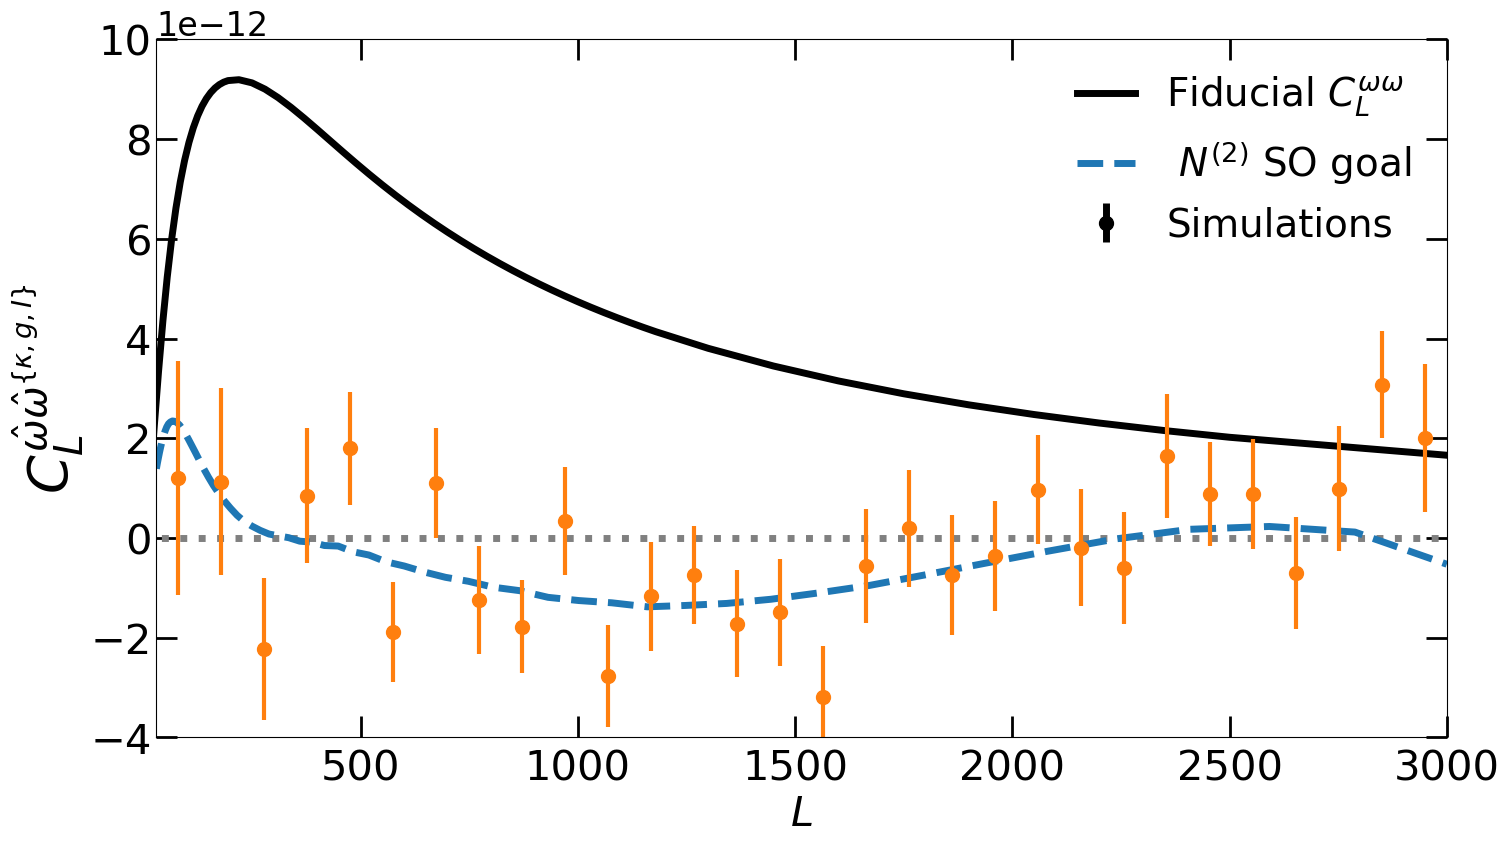

In [14]:
plt.rcParams['figure.figsize'] = [15, 9]
plt.rcParams['xtick.major.pad']='8'
plt.rc('figure', facecolor='w')
fig, ax = plt.subplots(1,1)
fig.tight_layout(pad=6)


ps_bin, ks_bin, err_bin = get_ps_binned(ks, ps, 30)

ax.plot([0,3000],[0,0], linestyle=":", color="grey", linewidth=5)

ax.plot(omega_Ls, omega_ps, label="Fiducial $C_{L}^{\omega\omega}$", color="k", linewidth=5)
ax.plot(Ls, N, label=" $N^{(2)}$ SO goal", linewidth=5, linestyle="--")


ax.errorbar(ks_bin, ps_bin/((2 * np.pi)**2 ) , err_bin/((2 * np.pi)**2 ),fmt = ".", linewidth=3, markersize=20)

ax.errorbar([-1],[-1], [1], color="k", label="Simulations", ls='none', fmt=".", markersize=20, linewidth=5)

ax.set_xlim(3e1,3e3)
ax.set_ylim(-4e-12,1e-11)
ax.yaxis.get_offset_text().set_fontsize(24)
ax.legend(prop={'size': 28}, frameon=False, handlelength=1.5)
ax.set_ylabel("$C_{L}^{\hat{\omega}\hat{\omega}^{\{\kappa,g,I\}}}}$", fontsize=40)
ax.set_xlabel("$L$", fontsize=30)
ax.tick_params(top=True, right=True, direction="in", which="minor", length=10, width=1.5)
ax.tick_params(top=True, right=True, direction="in", which="major", length=15, width=2)
ax.tick_params(labelsize=30)

# fig.savefig("_report_plots/bias_results_sim.pdf", bbox_inches='tight')
plt.show()